# Classification supervised algorithms

For the classification systems we are going to use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

## Loading data

Because MNIST is a popular dataset, it can be downloaded by using Scikit-Learn. The following code fetches the MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784',version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including

- A DESCR key describing the dataset.
- A data key containing an array with one row per instance and one column per feature.
- A target key containing an array with the labels.

Now let's look at these arrays:

In [4]:
X, y = mnist["data"].to_numpy(),mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features, corresponding to the pixels.

Let's take a peek at one digit from the dataset. To do this lets grab an instances feature vector, reshape it to a 28x28 array, and display it using Maplotlib's imshow() function:

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

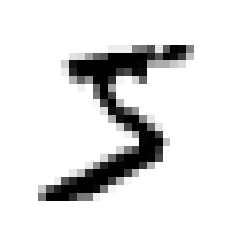

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=mpl.cm.binary,interpolation='nearest')
plt.axis('off')
plt.show

This looks like a 5 and we can confirm looking at y[0]

In [10]:
y[0]

'5'

The result is a strin with the '5', lets convert it to a number

In [12]:
import numpy as np
y = y.astype(np.uint8)

## Splitting the set into test and training sets

You should always create a test set and set it aside before inspecting the data closely. Th MNIST dataset is actually alredy split into a training set (the first 60,000 images) and a test set(the last 10,000 images)

In [14]:
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:],y[:60000],y[60000:]

## Training a Binary Classifier

First lets simplify the problem for now and only try to identify one digit, in this case the number 5. This "5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let's create the target vectors for this classification task:

In [16]:
y_train_5 = (Y_train == 5)
y_test_5 = (Y_test == 5)

For this problem, we are going to use the Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn's SGDClassifier class. 

In [17]:
from sklearn.linear_model import SGDClassifier

In [21]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Lets see if it can predict the 5 in the first data X[0]

In [22]:
sgd_clf.predict([some_digit])

array([ True])

So the classifier guesses the image right 5(True). Now let's evaluate this model's performance

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor. 

### Measuring Accuracy Using Cross-Validation

For this time, lets implement cross validation ourself using Scikit-Learn StratifiedKFold

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [25]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [26]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


At each iteration the code creates a clone of the classifier, trains that clone on the training folds and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

Now using the cross_val_score() function to evaluate the SGDClassifier model using K-fold cross-validations, also with three folds.

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

The accuracy is above 95% (ratio of correct predictions). But, let's look at a very dumb classifier that just classifies every single image in the "not-5" class:

In [31]:
from sklearn.base import BaseEstimator

In [36]:
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [37]:
never_5_clf = Never5Classifier()

In [38]:
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

The model has over 90% accuracy. But this is simple because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time

Thats why accuracy is generally not the preferred performance measure for classifiers, especially when dealing with skewed datasets.

### Confusion Matrix

Another way to evaluate the performace of a classifier is to look at the confusion matrix. The idea is to count the number of times instances of class A are classified as class B.

In order to compute the confusion matrix, first we need to have a set of predictions, to compare to the actual targets. Let's use the cross_val_predict() function

In [43]:
from sklearn.model_selection import cross_val_predict

In [44]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

The method gives a clean prediction for each instance in the training set.

To get the confusion matrix lets use the confusing_matrix() function. 

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

The first row of this matrix considers non-5 images: 53892 were correctly classified as non-5s, while the remaining 687 were wrongly classified as 5s. The second row considers the images of 5s: 1891 were wrongly classified as non-5s, while the remaining 3530 were correctly classified as 5s

The confusion matrix give a lot of information, but it will be desired to have a more concise metric. An interesting one to look is the precision of the classifier, which is defined by the cocient between the TP (number of true positives) over the sum of TP plus FP(number of false positives). Precision is typically used along with another metric named recall which is the cocient between TP over TP plus FN (false negatives)

### Precision and Recall

Scikit-Learn provides functions to compute classifier metrics, including precision and recall:

In [46]:
from sklearn.metrics import precision_score, recall_score

In [47]:
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [48]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

With precision and recall, it seems that the model does not look as shiny as it did when we looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.11% of the 5s.

It's convenient to combine precision and recall into a single metric called F_1 score, which is the harmonic mean of precision and recall.

In [49]:
from sklearn.metrics import f1_score

In [50]:
f1_score(y_train_5,y_train_pred)

0.7325171197343846

Depending on the project, you will get more care about precision or recall, but remember that one increase while the other decrease. This is called Precision/Recall Tradeoff

### Precision / Recall Tradeoff

Scikit-Learn allows to find a balance between the precision and the recall. This can be done by using the decision_function() method instead of the predict() method, which return a score for each instance, and then make predictions based on those scores giving the threshold.

In [51]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [52]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)

In [53]:
y_some_digit_pred

array([ True])

Ths SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as predict() method. Let's raise the threshold

In [54]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

That confirms that raising the threshold decreases recall. The classifier detects it when the threshold was 0, buy misses it when the threshold was 8000.

To select properly the threshold, all the scores of all instances in the training set need to be get using cross_val_predict() function again, but specifyin that you want it to return decision scores instead of predictions.

In [95]:
y_scores = cross_val_predict(sgd_clf, X_train,y_train_5,cv=3,
                             method='decision_function')

With the obtained scores, precision and recall can be computed for all possible thresholds using the precision_recall_curve() function:

In [96]:
from sklearn.metrics import precision_recall_curve

In [97]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

Finally a plot precision and recall as functions of the threshold value can be plotted using the Matplotlib

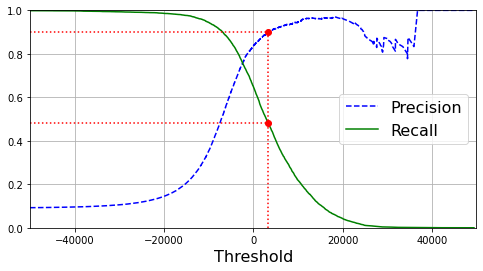

In [100]:
def plot_precision_recall_vs_threshold(precisions,recalls,tresholds):
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'g-',label='Recall')
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold',fontsize=16)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.plot([threshold_90_precision,threshold_90_precision],[0.,0.90],'r:')
plt.plot([-50000,threshold_90_precision],[0.9,0.9],'r:')
plt.plot([-50000,threshold_90_precision],[recall_90_precision,recall_90_precision],'r:')
plt.plot([threshold_90_precision],[0.9],'ro')
plt.plot([threshold_90_precision],[recall_90_precision],'ro')
plt.show()

It can be appreciated that the precision curve is bumpier that the recall curve, specially at the end. The reason is that precision may sometimes go down when you raise the threshold.

Another way to select a good precision / recall tradeoff is to plot precision directly against the recall.

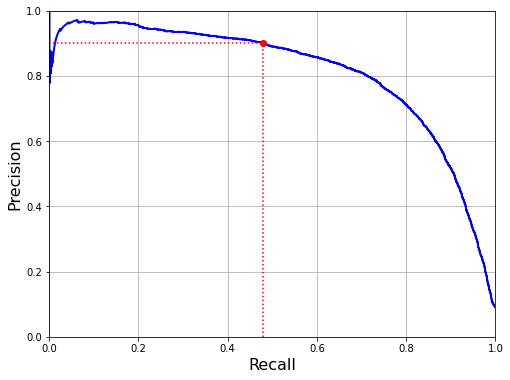

In [102]:
def plot_precision_vs_recall(precisions,recalls):
    plt.plot(recalls,precisions,'b-',linewidth=2)
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.axis([0,1,0,1])
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions,recalls)
plt.plot([recall_90_precision,recall_90_precision],[0.,0.9],'r:')
plt.plot([0.0,recall_90_precision],[0.9,0.9],'r:')
plt.plot([recall_90_precision],[0.9],'ro')
plt.show()

It can be seen that the precision really starts to fall around 80% recall. A precision/recall tradeoff can be selected before that drop starts, for example at around 60% recall. But it will depends on the project

For this project we want a 90% precision. So let's find the threshold precisily with np.argmax() and it's already calculated in threshold_90_precision

In [103]:
threshold_90_precision

3370.0194991439557

Now to make predictions (on the training set for now), instead of calling the classifiers predict() method, the following code can be run:

In [104]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Checking the predictions precision and recall:

In [105]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [107]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

By selecting the threshold now we have a 90% precision classifier!

Remember to have the precision value as far as high without letting have a lower recall.

### The ROC curve

The receiver operating characteristic ROC curve is another metric used in binary classifiers. The ROC curve plots the true positive rate (recall, TPR) against the false positive rate (FPR). The ROC curve plots sensitivity (recall) versus 1 - specificity.

To plot the ROC curve, first we need to compute the TPR and FPR for various threshold values, using the roc_curve() function:

In [108]:
from sklearn.metrics import roc_curve

In [109]:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

Now lets plot the TPR vs the FPR using Matplotlib

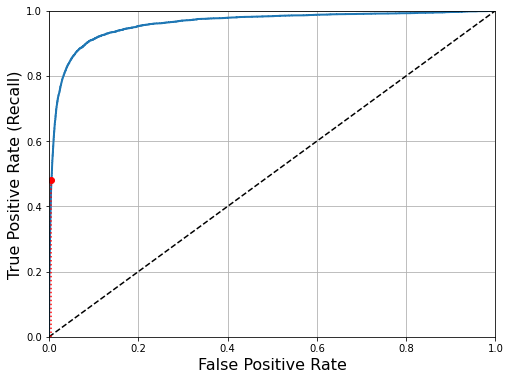

In [113]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate (Recall)',fontsize=16)
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90,fpr_90],[0.,recall_90_precision],'r:')
plt.plot([0.0,fpr_90],[recall_90_precision,recall_90_precision],'r:')
plt.plot([fpr_90],[recall_90_precision],'ro')

The higher the recall (TPR), the more false positives (FPR) the classifier produces. The black dotted line represents the ROC curve of a purely random classifier, a good classifier stay as far away from that line as possible.

One way to compare classifiers is to measure the area under the curve (UAC). A perfect classifier will have a ROC AUC of 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

Scikit-Learn provides a function to compute the ROC AUC:

In [114]:
from sklearn.metrics import roc_auc_score

In [115]:
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

Now let's used the RandomForestClassifier algorithm and comprate its ROC curve AUC score to the SGDClassifier

## Random Forest Classifier

First scores for each instance in the training set must be obtained.

But the Random Forest Classifier has a predict_proba() method, returning an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class

In [116]:
from sklearn.ensemble import RandomForestClassifier

In [118]:
forest_clf = RandomForestClassifier(random_state=42)

In [119]:
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,
                                   method='predict_proba')

The obtained its in probabilities, so let's convert it to scores, using the positive class's probability as the score

In [121]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Now we have the data for the ROC curve, so lets compare it with the SGDClassifier

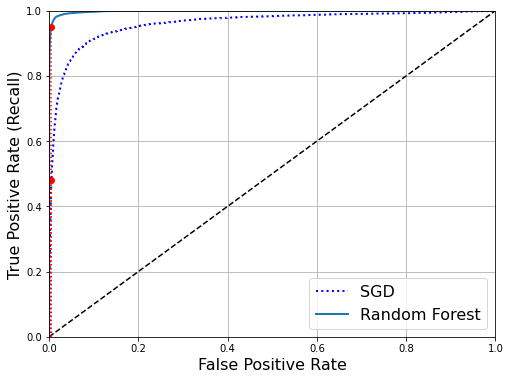

In [122]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,'b:',linewidth=2,label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'Random Forest')
plt.plot([fpr_90,fpr_90],[0.,recall_90_precision],'r:')
plt.plot([0.0,fpr_90],[recall_90_precision,recall_90_precision],'r:')
plt.plot([fpr_90],[recall_90_precision],'ro')
plt.plot([fpr_90,fpr_90],[0.,recall_for_forest],'r:')
plt.plot([fpr_90],[recall_for_forest],'ro')
plt.grid(True)
plt.legend(loc='lower right',fontsize=16)
plt.show()

The RandomForestClassifier ROC curve looks much  than the SGDClassifiers, it comes much closer to the top-left corner. Its ROC AUC should be higher

In [123]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

And measuring the precision and recall

In [124]:
train_pred_forest = cross_val_predict(forest_clf, X_train,y_train_5,cv=3)

In [126]:
precision_score(y_train_5,train_pred_forest)

0.9905083315756169

In [127]:
recall_score(y_train_5,train_pred_forest)

0.8662608374838591

Nice! a 99% precision with a 86%. Not too bad!

At this point we train a binary classifier, choosing the appropiate metric for the task, evaluate the classifiers using cross-validation, select the precision / recall tradeoff that fits the needs, and compare vaious models using ROC curves and ROC AUC scores. Now let's try to detect more than just the 5s

# Multiclass Classification

Multiclass classifiers can distinguish between more than two classes.

First let's try the SGDClassifier to train the training set using the original target classes from 0 to 9, Scikit-Learn actually trained 10 binary classifiers.

### SGDClassifier

In [129]:
sgd_clf.fit(X_train,Y_train)

SGDClassifier(random_state=42)

In [143]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In this case the model makes a prediction from the scores selecting the class with the highest score.

This can be seen with the decision_function() method, now it will return 10 scores per instance, one per class

In [145]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Returning the highest score

In [146]:
np.argmax(some_digit_scores)

3

Another option is to use one-versus-one or one-versus-all, by using the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a binary classifier to its constructor. Lets make one multiclass classifier using the OvO strategy, based on a SGDClassifier

### OneVsOneClassifier

In [150]:
from sklearn.multiclass import OneVsOneClassifier

In [151]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,Y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [153]:
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [154]:
len(ovo_clf.estimators_)

45

### RandomForestClassifier

Let's train now a Random Forest Classifier

In [155]:
forest_clf.fit(X_train,Y_train)

RandomForestClassifier(random_state=42)

In [156]:
forest_clf.predict([some_digit])

array([5], dtype=uint8)

This time Scikit-Learn did a directly classify into multiple classes instead a OvA or OvO. By using the method predict_proba() all the probabilities can be get.

In [158]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

The classifier is fairly confident about its prediction: the 0.9 at the 5th index in the array means that the model estimates a 90% probability that the image represents a 5.

Now lets evaluate these classifiers with cross_val_score function to evaluate the SGDClassifier's accuracy

In [159]:
cross_val_score(sgd_clf,X_train,Y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

With this we are getting over 85% on all test folds, compared by using a random classifier which will get a 10% accuracy, is not bad, but it can be improved. For example, simply scaling the inputs increases accuracy above 89%

In [163]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [164]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [166]:
cross_val_score(sgd_clf,X_train_scaled,Y_train,cv=3,scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error analysis

One way to improve the model is to analyzing the type of errors it makes. First, let's look at the confusion matrix, using the cross_val_predict() function, then call the confusion_matrix() function.

In [167]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,Y_train,cv=3)

In [168]:
conf_mx = confusion_matrix(Y_train,y_train_pred)

In [169]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

When can see that the main diagonal has the higher numbers, thats because the algorithm predict well, but it's more convenient to look at an image representation of the confusion matrix, lets use Matplotlib's matshow() function:

<function matplotlib.pyplot.show(close=None, block=None)>

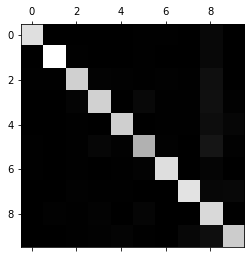

In [170]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show

With the graph we confirm that the most images are on the main diagonal, which means that they where classified correctly.

Now let's focus on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class, so we can compare error rates instead of absolute of errors

In [171]:
row_sums = conf_mx.sum(axis=1,keepdims=True)

In [174]:
norm_conf_mx = conf_mx / row_sums

But to plot it we need to fill the diagonal with zeros to keep only the errors

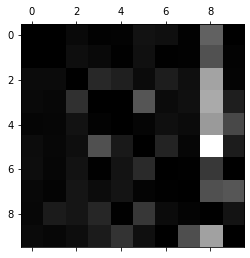

In [176]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

With the graph we can see the kinds of errors that the classifier makes. The rows represent actual classes, while columns represent predicted classes. For this dataset it can be inferred that the 8 is the most misclassfied, since its the column that brightness more.

Analyzing the confusion matrix can give insights on ways to improve the classifier. For this case the efforts should be spent on reducing the false 8s, by gathering more training data for digits that look like 8s (but are not), or writting an algorithm to count the number of closed loops (e.g. 8 has two, 6 has one and 5 has none). Or maybe preprocessing the images using Scikit-Image, Pillow or OpenCV).

Another way it by analyzing individual errors, for example, let's plot examples of 3s and 5s using the plot_digits() function.

In [178]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

<function matplotlib.pyplot.show(close=None, block=None)>

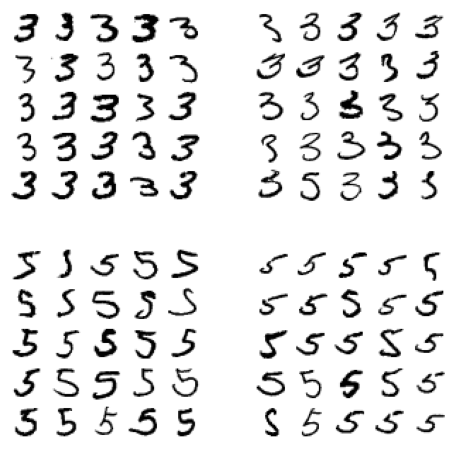

In [179]:
cl_a, cl_b = 3,5
X_aa = X_train[(Y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(Y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(Y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(Y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show

The main diagonal has the classification for the 3s and 5s. And the not main diagonal contains some numbers that were misclassified, but some of them are so badly written that even a human would have trouble classifying them (e.g. the 5 on the 1st row and 2nd column of the bottom left set). But other errors seems like obvious errors to us, and it's hard to understand why the classifier made the mistakes. The reason is the approach that we did, using a simple SGDClassifier, which is a linear model, assigning a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intesities to get a score for each class. Because the 3s and 5s differ only by few pixels, the model can be easily confused.

The main difference between 3s and 5s is the position of the small line that joins the top line of the bottom arc. So this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated

## Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance.

For this classification we will take the 7, 8 and 9 and also indicate if the number is odd using a KNeighborsClassifier.

In [186]:
from sklearn.neighbors import KNeighborsClassifier

In [192]:
y_train_large = (Y_train >= 7)
y_train_odd = (Y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

In [194]:
knn_clf = KNeighborsClassifier()

Now let's create a KNeighborsClassifier instance 

In [195]:
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

Now let's make a prediction, and notice that it outputs two labels

In [196]:
knn_clf.predict([some_digit])

array([[False,  True]])

Correct! The digit 5 is indeed not large (False) and odd(True).

Now let's evaluate the multilabel classifier, as we did before with the F1 score, measuring the F1 score for each individual label, and computing the average score.

In [197]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train,y_multilabel, cv=3)

In [199]:
f1_score(y_multilabel,y_train_knn_pred,average='macro')

0.976410265560605

This assumes that all labels are equally important.

## Multioutput Classification

Another type of classification is the Multioutput Classification, it's simply a generalization of multilabel classificiation. To illustrate this, let's build a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intesities. The classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system

First let's create the training and test set by taking the MNIST images and adding noise to their pixel intensities using NumPy's randint() function. The target images will be the original images:

In [201]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let's take a peek at an image from the test set

In [203]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

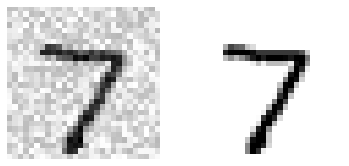

In [204]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

On the left side is the noisy input image, and on the right is the clean target image. Now let's train the classifier and make it clean this image with a KNeighbors Classifier

In [205]:
knn_clf.fit(X_train_mod,y_train_mod)

KNeighborsClassifier()

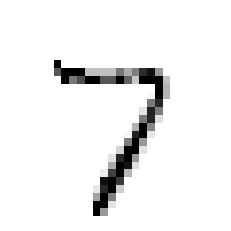

In [211]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Looks close enough to the target!

With this it concludes the tour on classification.